# Classifier Exploration

Goal: Determine a method to map Azure’s five output metrics (accuracy, pronunciation, completeness, fluency, prosody) to a binary correct/incorrect classification.

## Code Setup

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [99]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [55]:
data = pd.read_csv("classifier_data.csv")


def plot_confusion_matrix(title, predicted, actual=data["correct"]):
    fig, ax = plt.subplots(figsize=(5, 4))

    ConfusionMatrixDisplay(
        confusion_matrix(actual, predicted, labels=[True, False]).T,
        display_labels=["Correct", "Incorrect"],
    ).plot(
        ax=ax,
        cmap="Greens",
        colorbar=False,
        text_kw={"fontsize": 12},
    )

    # Clear Labels
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Set Ticks
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Actually Correct", "Actually Incorrect"], rotation=0)
    ax.set_yticklabels(["Predicted\nCorrect", "Predicted\nIncorrect"], rotation=0)
    ax.xaxis.tick_top()

    # Title
    fig.suptitle(title, y=1.08, fontsize=16)
    plt.title(
        f"Accuracy: {accuracy_score(actual, predicted):.2f}",
        pad=30,
        fontsize=11,
    )
    plt.show()

## Comparing Classifier Methods

### Aidan's Method

Aidan had been performing classification by taking the average of all output metrics—accuracy, completeness, fluency, pronunciation, prosody—and classifying as correct if the average was above 55 (out of 100).

This was tested on all 128 samples (64 recordings matched to the correct word and one incorrect word), and seeing if the classification method could predict correctness based on the output metrics.

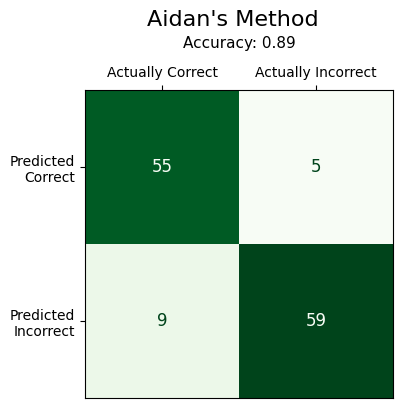

In [127]:
aidan_method = (
    data[
        [
            "accuracy",
            "completeness",
            "fluency",
            "pronunciation",
            "prosody",
        ]
    ].mean(axis=1)
    > 55
)
plot_confusion_matrix("Aidan's Method", aidan_method)

Aidan's method was able to predict correctness with an accuracy of 89%. This method tended to predict "incorrect" slightly more often, resulting in more false negatives (predicting incorrect when correct) than false positives.

### Logistic Regression Method

In [89]:
# Define Logistic Regression Classifier Function
def logistic_regression_classifier(cols):
    X = data[cols].fillna(0)
    y = data["correct"].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=3
    )
    # Logistic Regression
    lr_model = LogisticRegression(random_state=3).fit(X_train, y_train)
    return lr_model.predict(X_test), y_test

I then tried using a logistic regression model perform this classification, using all out metrics and independent variables. I used an 80/20 train-test split, so the confusion matrix will only show 26 test samples.

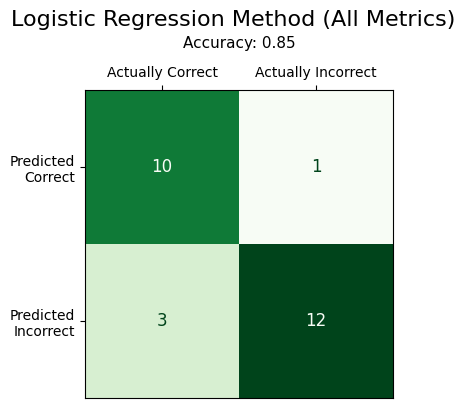

In [ ]:
lr_predicted, lr_actual = logistic_regression_classifier(
    [
        "accuracy",
        "completeness",
        "fluency",
        "pronunciation",
        "prosody",
    ]
)
plot_confusion_matrix(
    "Logistic Regression Method (All Metrics)", lr_predicted, lr_actual
)

Using a logistic regression with all five output metrics gave an accuracy of 85%, 4% worse than Aidan's method. This method similarly predicted "incorrect" more often.

I figured the regression could be improved by removing some of the inputs. The five output metrics are all quite correlated, which could increase overfitting.

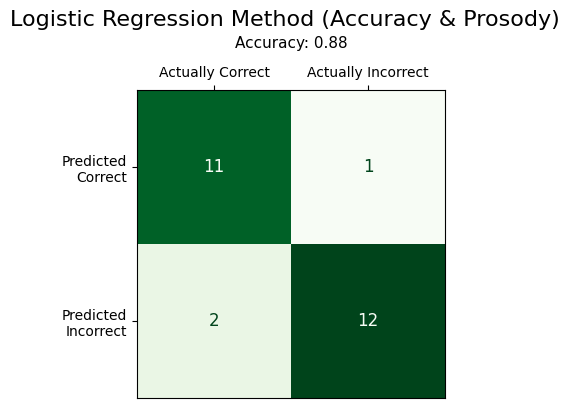

In [98]:
lr_predicted, lr_actual = logistic_regression_classifier(["accuracy", "prosody"])
plot_confusion_matrix(
    "Logistic Regression Method (Accuracy & Prosody)", lr_predicted, lr_actual
)

I tried running the classifier only using accuracy and prosody, which improved the accuracy to 88%, still 1% under Aidan's method. While I used accuracy and prosody in this example, I found that other combinations of metrics resulted in the exact same accuracy and confusion matrix, such as: `Accuracy + Completeness + Pronunciation`, `Pronunciation + Prosody`, and likely others.

#### Logistic Regression Conclusion

From this exploration, I found that not only did logistic regression classifiers result in a lower accuracy that Aidan's method, Aidan's method also has the added benefit of simplicity. The threshold used in Aidan's method additionally allows for greater fine tuning, and can be dynamic throughout the game. For example, we can increase the threshold on the first attempt, only allowing answer with a high level of accuracy to pass on the first try, and encouraging more students to try again. We could then lower the threshold, allowing more students to pass on the second attempt, and only requiring a third attempt for students that need it.

Further exploration of logistic regression could be performed—for example I beleive my 20% test split was not large enough to see granular differences between methods—however, I believe the simplicity of a threshold outweighs any accuracy improvements that might be achieved with a more complex model.

### Accuracy Threshold Method

Lastly, I attempted to just use a single threshold on accuracy to perform the classification, using the same 55 threshold as Aidan's method.

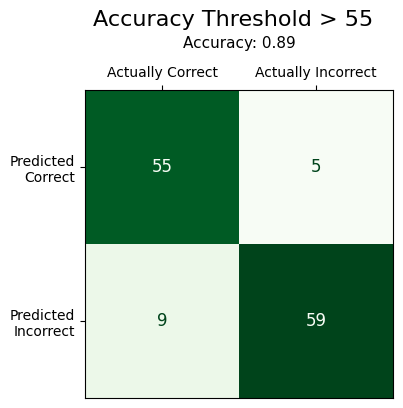

In [126]:
accuracy_threshold = data["accuracy"] > 55
plot_confusion_matrix("Accuracy Threshold > 55", accuracy_threshold)

This performed identically to Aidan's method, with the same accuracy and confusion matrix.

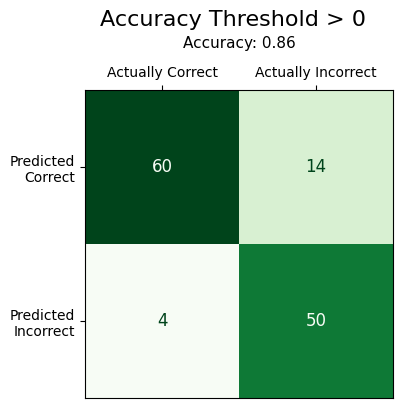

In [128]:
accuracy_threshold = data["accuracy"] > 0
plot_confusion_matrix("Accuracy Threshold > 0", accuracy_threshold)

Interestingly, a threshold of 0 (treating anything that doesn't have an accuracy of 0 as correct) maintained a high accuracy of 86%. Naturally this method tended to result in more false positives (predicting correct when incorrect), but it is interesting to see that most incorrect answers simply have an accuracy of 0.

## Conclusion

From this exploration, I reccomend using a single threshold on accuracy to perform the classification—keeping it simple and maintaining a solid accuracy, as well as providing flexibilty to tweak the threshold at different points in the game.